In [0]:
dbutils.widgets.removeAll()
dbutils.widgets.text("patient_id", "", "Patient ID")
dbutils.widgets.dropdown("order", "Newest", ["Newest", "Oldest"], "Sort Order")
dbutils.widgets.text("page", "1", "Page Number")
dbutils.widgets.text("page_size", "20", "Page Size")
dbutils.widgets.dropdown("mpr", "ALL", ["SAG", "TRA", "COR", "ALL"], "MPR")
dbutils.widgets.dropdown("position", "ALL", ["HFS", "FFS", "ALL"], "Patient Position")
dbutils.widgets.dropdown("similar_height", "OFF", ["ON", "OFF"], "Search by Similar Height")
dbutils.widgets.dropdown("similar_weight", "OFF", ["ON", "OFF"], "Search by Similar Weight")
dbutils.widgets.dropdown("similar_sex", "OFF", ["ON", "OFF"], "Search by Similar Sex")

In [0]:
%pip install nibabel
%pip install pydicom matplotlib
dbutils.library.restartPython()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


,patient_sex,patient_height,patient_weight,mpr,patient_position,image,image_id,series_id,study_id,patient_id,date,time,path
0,M,1.8,80,,,,,,,,,,
1,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.13775653113426566614640759494283975415,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851692,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_002.ima
2,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.373418983112238817731819867112568336494,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851645,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_004.ima
3,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.154383475412912617737892676020360474297,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851597,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_006.ima
4,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.302477155811786404621283175871984354964,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851550,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_008.ima
5,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.190372640213385433109596829540068042934,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851502,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_010.ima
6,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.380923935712150652541215747950617354423,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851455,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_012.ima
7,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.322976642311503219035996945164269275068,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851407,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_014.ima
8,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.85313818712839350501251751771069690466,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851360,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_001.ima
9,F,1.8,80,TRA,FFS,,1.3.6.1.4.1.9590.100.1.2.115074558411323690923914769212603616901,1.3.12.2.1107.5.2.40.50233.2016062115405165020118420.0.0.0,1.3.12.2.1107.5.2.40.50233.30000016062107154769200000019,528,2016-06-21,153851312,/Volumes/dbms/bronze/lumbar-spine-dataset/MRI-data/0528/L-SPINE_CLINICAL_LIBRARIES_20160621_152924_187000/T1_TSE_TRA_0005/T1_TSE_TRA__0528_003.ima

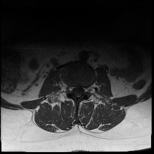
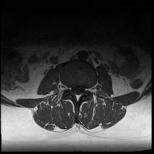
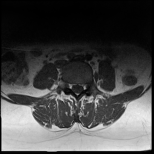
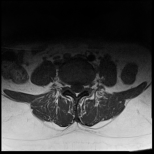
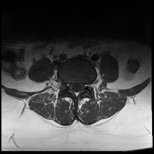
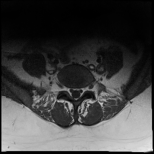
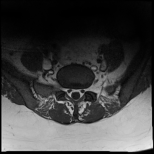
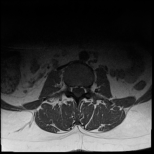
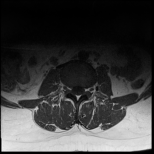
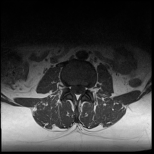
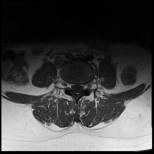
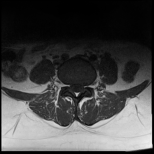
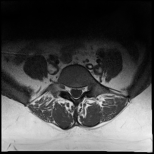
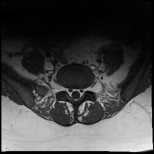
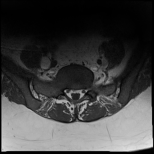
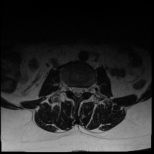
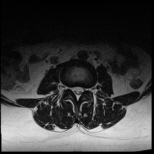
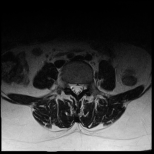
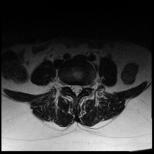
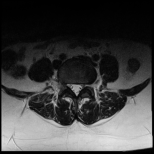

In [0]:
import pydicom
import matplotlib.pyplot as plt

patient_id = dbutils.widgets.get("patient_id")
order = dbutils.widgets.get("order")
page = int(dbutils.widgets.get("page"))
page_size = int(dbutils.widgets.get("page_size"))
similar_sex = dbutils.widgets.get("similar_sex")
similar_height = dbutils.widgets.get("similar_height")
similar_weight = dbutils.widgets.get("similar_weight")
mpr = dbutils.widgets.get("mpr")
position = dbutils.widgets.get("position")
offset = (page - 1) * page_size

# Only include sex, height, weight in ref_study
ref_study = spark.sql(
    f"""
    SELECT 
        s.patient_sex, 
        s.patient_height, 
        s.patient_weight
    FROM dbms.silver.study s
    WHERE s.patient_id = '{patient_id}'
    LIMIT 1
    """
).first()

where_clauses = []

if similar_sex == "ON" and ref_study:
    where_clauses.append(f"s.patient_sex = '{ref_study['patient_sex']}'")

if similar_height == "ON" and ref_study:
    where_clauses.append(f"s.patient_height = {ref_study['patient_height']}")

if similar_weight == "ON" and ref_study:
    where_clauses.append(f"s.patient_weight = {ref_study['patient_weight']}")

if mpr != "ALL":
    where_clauses.append(f"se.mpr = '{mpr}'")

if position != "ALL":
    where_clauses.append(f"s.patient_position = '{position}'")

where_sql = " AND ".join(where_clauses) if where_clauses else "1=1"

query = f"""
SELECT 
  f.*, 
  s.study_date AS date, 
  i.image_time AS time, 
  i.path,
  s.patient_sex,
  s.patient_height,
  s.patient_weight,
  se.mpr,
  s.patient_position
FROM dbms.gold.fact_img f
LEFT JOIN dbms.gold.dim_study s ON f.study_id = s.uid
LEFT JOIN dbms.gold.dim_image i ON f.image_id = i.sop_instance_uid
LEFT JOIN dbms.silver.series se ON f.series_id = se.uid
WHERE {where_sql}
ORDER BY s.study_date {'DESC' if order == 'Newest' else 'ASC'}, i.image_time {'DESC' if order == 'Newest' else 'ASC'}
LIMIT {page_size} OFFSET {offset}
"""

df = spark.sql(query)

rows = df.collect()

import io
import base64

def dicom_to_base64_png(path):
    try:
        ds = pydicom.dcmread(path)
        fig, ax = plt.subplots(figsize=(2,2))
        ax.imshow(ds.pixel_array, cmap=plt.cm.gray)
        ax.axis('off')
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')
        return f'<img src="data:image/png;base64,{img_base64}" width="128"/>'
    except Exception:
        return ''

display_rows = []
for row in rows:
    row_dict = row.asDict()
    path = row_dict.get('path')
    row_dict['image'] = dicom_to_base64_png(path) if path else ''
    row_dict['patient_sex'] = row_dict.get('patient_sex', '')
    row_dict['patient_height'] = row_dict.get('patient_height', '')
    row_dict['patient_weight'] = row_dict.get('patient_weight', '')
    row_dict['mpr'] = row_dict.get('mpr', '')
    row_dict['patient_position'] = row_dict.get('patient_position', '')
    display_rows.append(row_dict)

import pandas as pd

original_info = {
    'patient_sex': ref_study['patient_sex'] if ref_study else '',
    'patient_height': ref_study['patient_height'] if ref_study else '',
    'patient_weight': ref_study['patient_weight'] if ref_study else '',
    'mpr': '',
    'patient_position': '',
    'image': '',
}
if display_rows:
    for col in display_rows[0]:
        if col not in original_info:
            original_info[col] = ''
pd_df = pd.DataFrame([original_info] + display_rows)

from IPython.display import display as ipy_display, HTML
columns_to_display = [
    'patient_sex', 'patient_height', 'patient_weight', 'mpr', 'patient_position', 'image'
] + [
    col for col in pd_df.columns if col not in ['patient_sex', 'patient_height', 'patient_weight', 'mpr', 'patient_position', 'image']
]
if not pd_df.empty:
    ipy_display(HTML(pd_df[columns_to_display].to_html(escape=False)))
else:
    ipy_display(HTML("<b>No results found.</b>"))